<a href="https://colab.research.google.com/github/supertime1/Kaggle/blob/main/Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introcudtion

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to
this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).


Attribute information:
1.   age 
2.   sex
3.   chest pain type (4 values)
4.   resting blood pressure
5.   serum cholestoral in mg/dl
6.   fasting blood sugar > 120 mg/dl
7.   resting electrocardiographic results (values 0,1,2)
8.   maximum heart rate achieved
9.   exercise induced angina
10.  oldpeak = ST depression induced by exercise relative to rest
11.  the slope of the peak exercise ST segment
12.  (ca) number of major vessels (0-3) colored by flourosopy
13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

#1. Import Data

In [ ]:
import numpy as np
import sklearn
import itertools
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/Kaggle Dataset/UIC Heart Disease/heart.csv'
df = pd.read_csv(file_path, header=0, sep=',')

#2.Visualize Data

In [4]:
print(f'The dataset has {len(df.columns)} features and {len(df)} samples')

The dataset has 14 features and 303 samples


In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


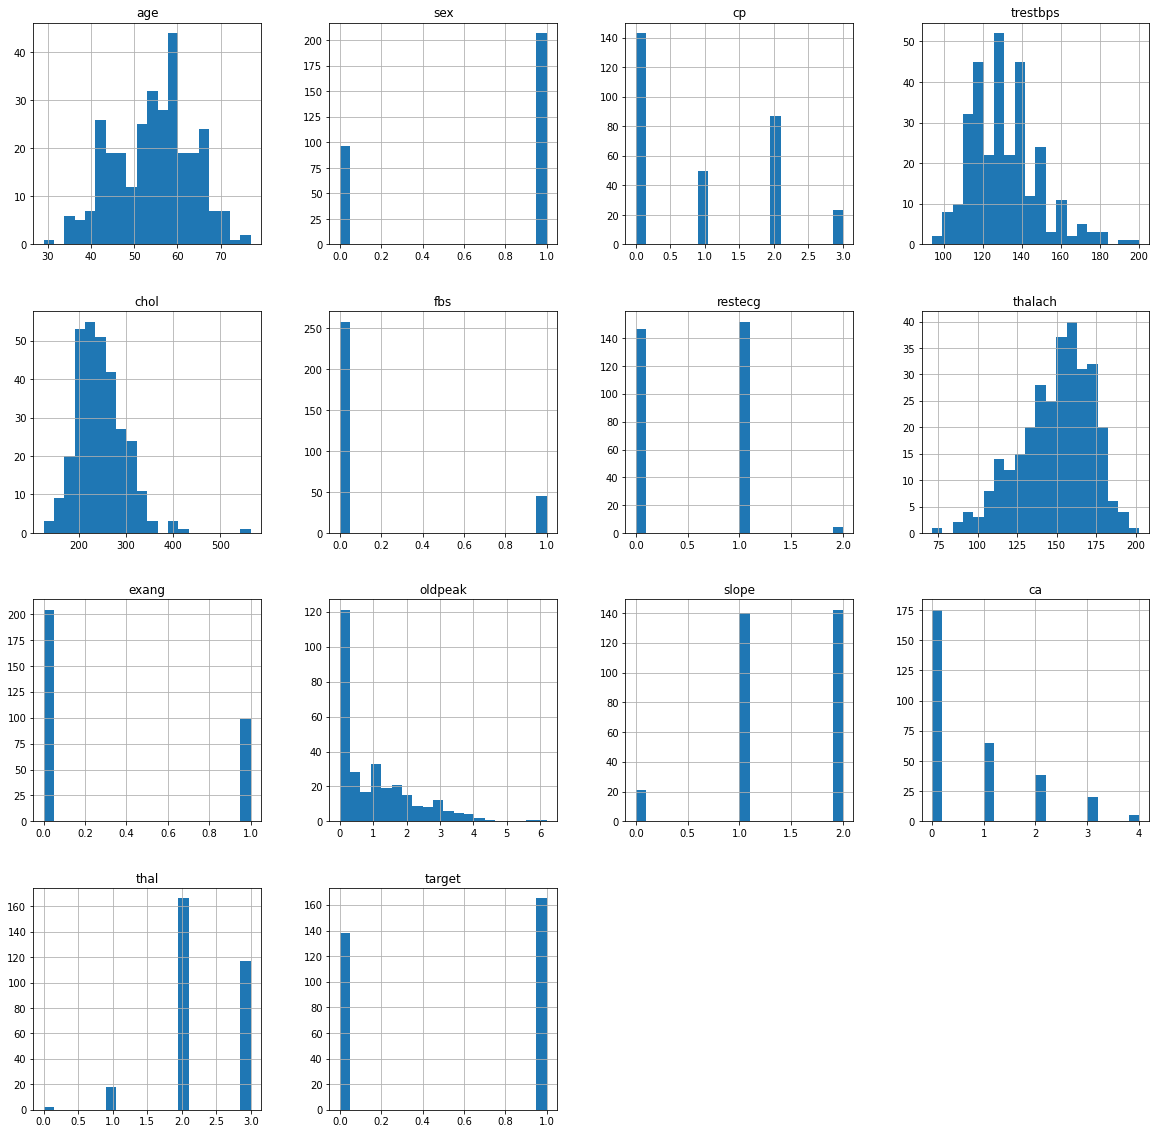

In [6]:
df.hist(bins=20, figsize=(20,20))
plt.show()

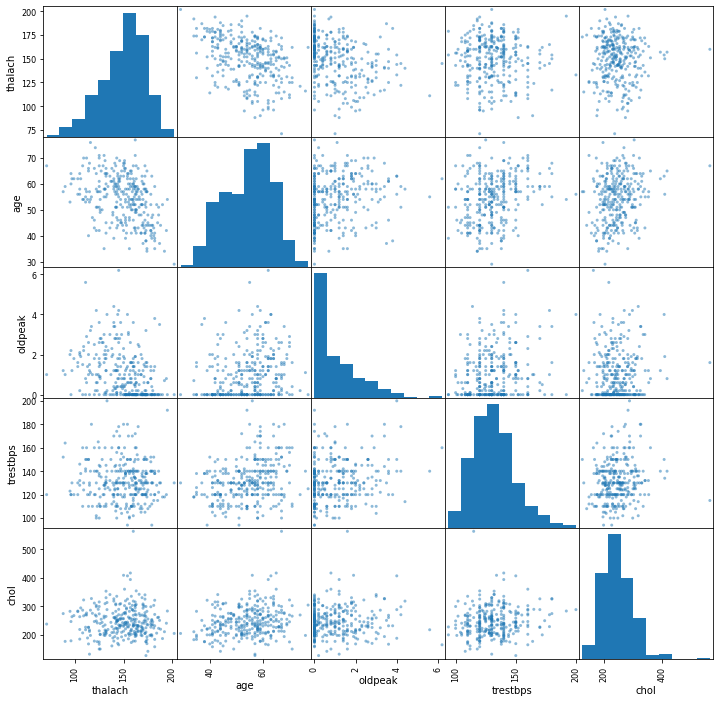

In [7]:
#correlation
from pandas.plotting import scatter_matrix
attributes = ['thalach', 'age', 'oldpeak', 'trestbps', 'chol']
scatter_matrix(df[attributes], figsize=(12,12))
plt.show()

To do an extensive data analysis, we can perform analysis depending on the level of measurement, such as Pearson Correlation (continous vs continous), to find more:
1.  [Level of measurement vs. type of analysis](https://www.statisticssolutions.com/levels-of-measurement/#:~:text=Categorical%20variables%20are%20those%20that,a%20specific%20order%20to%20them.&text=Ordinal%20variables%20have%20two%20are,can%20be%20ordered%20or%20ranked.)
2.  [kai squared analysis for two categorical variables](https://datascience.stackexchange.com/questions/893/how-to-get-correlation-between-two-categorical-variable-and-a-categorical-variab)

#3. Split dataset into training and testing

In [131]:
# Select the most important feature to do a stratified shuffle split
# In this case, resting ECG results are choosen, but it should be based
# on domain knowledege 
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)
for train_idx, test_idx in split.split(df, df['target']):
    train_set = df.iloc[train_idx]
    test_set = df.iloc[test_idx]

In [132]:
print('Training data\n', train_set['target'].value_counts()/len(train_set))
print('\n\n Testing data\n', test_set['target'].value_counts()/len(test_set))

Training data
 1    0.545455
0    0.454545
Name: target, dtype: float64


 Testing data
 1    0.540984
0    0.459016
Name: target, dtype: float64


#4. Preprocess the data

In [133]:
# seperate the label and training data
heart_labels = train_set['target'].copy()
heart = train_set.drop('target', axis=1)

# preprocess the numerical features into pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


heart_num = heart.drop(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'], axis=1)
heart_cat = heart[['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']]

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='median')),
                         ('std_scaler', StandardScaler()),
])

num_attribs = list(heart_num)
cat_attribs = list(heart_cat)

full_pipeline = ColumnTransformer([
                                   ('num', num_pipeline, num_attribs),
                                   ('cat', OneHotEncoder(), cat_attribs),
])

full_pipeline_fit = full_pipeline.fit(heart)
heart_prepared = full_pipeline_fit.transform(heart)

#Train

Linear Regression

In [134]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(heart_prepared, heart_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [135]:
some_data = heart.iloc[:15]
some_labels = heart_labels.iloc[:15]
some_data_prepared = full_pipeline_fit.transform(some_data)
print('Predictions:', lin_reg.predict(some_data_prepared))
print('Labels:', list(some_labels))

Predictions: [ 0.33930143  1.18957088  1.0372973   0.67429492  0.3103646   0.15603424
 -0.19862331  0.80171059  0.55483424  0.91846755  0.60647081  0.65479962
  1.05968967  0.98062966  0.01436679]
Labels: [0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]


#Evaluate

In [141]:
def confusion_matrix(test_set, predictor, threshold, class_names, normalize):
    
    test_data = test_set.drop('target', axis=1)
    test_labels = test_set['target']
    test_data_prepared = full_pipeline_fit.transform(test_data)
    test_pred_raw = predictor.predict(test_data_prepared)
    test_pred = np.where(test_pred_raw < threshold, test_pred_raw, 1)
    test_pred = np.where(test_pred > threshold, test_pred, 0)
    # important to specify the label orders in confuction_matrix function
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred, labels=[0,1])
    
    def plot_confusion_matrix(cm, class_names, normalize):
        """
        Returns a matplotlib figure containing the plotted confusion matrix.

        Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
        """
        
        figure = plt.figure(figsize=(8, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
        plt.ylim()

        if normalize:
            cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

        # Use white text if squares are dark; otherwise black.
        threshold = cm.max() / 1.5

        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return figure

    plot_confusion_matrix(cm, class_names, normalize)

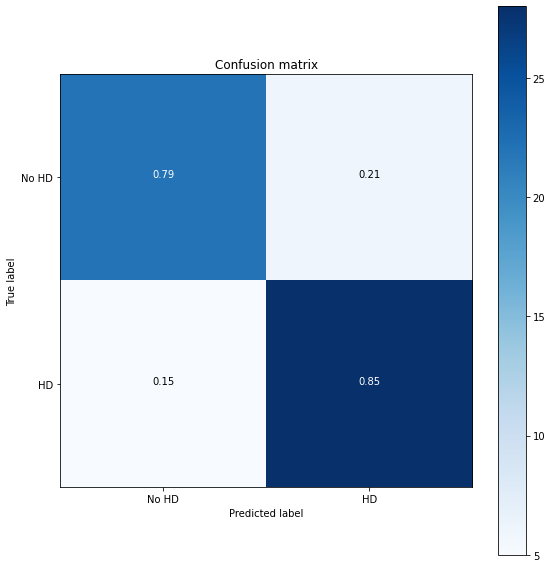

In [143]:
confusion_matrix(test_set, lin_reg, 0.5, ['No HD', 'HD'], True)

In [ ]:
def auc_curve_score()